In [7]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


encode_text_dummy(df, 'origin')

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)


# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
        

Final score (RMSE): 2.9371569088396146


,coef,positive
origin-1,-1.448374,False
cylinders,-0.416546,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629809,True
year,0.801274,True
origin-2,0.818566,True


Intercept: [-18.25753533]


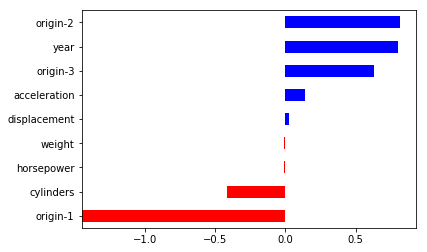

In [10]:
import sklearn
from sklearn import metrics
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")

# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


Final score (RMSE): 3.0409047603607178


,coef,positive
origin-1,-1.264483,False
weight,-0.007458,False
horsepower,-0.002799,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113755,True
year,0.787194,True


Intercept: [-17.27110481]


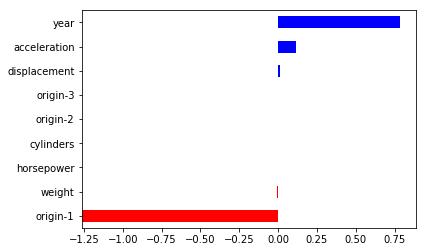

In [11]:
#L1 (Lasso) Regularization
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)
